# Double Antibody Application to a Single Tissue

**Question:** How does the stain sensitivity and specificity change when you apply the same antibody panel twice to a single tissue?

**Samples:** 
- A TMA containing HER2+ breast cancer tissue, purchased from Biomax. https://www.biomax.us/tissue-arrays/Breast/Her2B

**Method**: Cells were classified as tumor, endothelial, immune (T cell or macrophage) and stormal. For each stain, single cell pixel intensity in cells that should be positive was compared to cells that should be negative. For example, CD45 in T cells (i.e. specicifc signal) was compared to CD45 in tumor cells (i.e. non-specific background). The first (early) antibody application was compared to the second (late).


In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
import seaborn as sns

matplotlib.rcParams.update({'font.size': 12})

# K157 Analysis Steps

1 - use "good" markers (based on visual estimation of staining; low background markers) to define 5 tissue compartments.

2 - calculate the signal for each marker (expression in correct compartment) e.g. for CD45, T-cell cytoplasm

3 - calculate the background for each marker (expression in incorrect compartment) - e.g. for CD45, tumor nuclei

4 - Visualize intensity distribution of early and late signal and background

5 - Also estimate dynamic range and early/late correlation in ROIs using percentile (4th and 99th) 

## Load Data

In [2]:
#set location of files
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()

In [5]:
#load positive (thresholded using AF subtracted)
df_pos = pd.read_csv(f'{codedir}/Data/Her2B-K157-6S_DAPI22Q_Nuclei1000_ManualPositive.txt',index_col=0,sep='\t')
df_pos['slide'] = [item.split('_')[0] for item in df_pos.index]
df_pos['scene'] = [item.split('_')[1] for item in df_pos.index]

#read in full features (all locations, cells) (too big)
df_mi = pd.read_csv(f'{codedir}/BigData/features_Her2B-K157-6S_MeanIntensity.tsv',index_col=0,sep='\t')

df_mi['scene'] = [item.split('_')[0] for item in df_mi.index]# save smaller dataframes
#for s_scene in sorted(set(df_mi.scene)):
#    df_mi[df_mi.scene==s_scene].to_csv(f'{codedir}/Data/features_Her2B-K157-6S-{s_scene}_MeanIntensity.csv')

In [10]:
#still too big
#s_scene = 'scene002'
#df_mi.loc[df_mi.scene==s_scene,~df_mi.columns.str.contains('_Cells')].to_csv(f'{codedir}/Data/features_Her2B-K157-6S-{s_scene}_MeanIntensity.csv')

In [6]:
#load 
df_mi = pd.DataFrame()
for s_scene in ['scene002', 'scene004', 'scene005', 'scene006', 'scene008', 'scene009']:
    df_mi = df_mi.append(pd.read_csv(f'{codedir}/Data/features_Her2B-K157-6S-{s_scene}_MeanIntensity.csv',index_col=0))

In [8]:
#Define tissue compartments

#define tumor and immune cell types
ls_tumor = ['CK19_Ring','CK5_Ring','Ecad_Ring','CK14_Ring'] # #'CK7_Ring'= poor quench, CK17_Ring = too many pos comapred to CK5 and CK14
ls_exclude = ['CD31_Ring','CD68_Ring','CD4_Ring'] 
df_pos['all-tumor'] = df_pos.loc[:,ls_tumor].sum(axis=1)>=1 
df_pos['not-tumor'] = df_pos.loc[:,ls_exclude].sum(axis=1)>=1
df_pos['not-tumor-not-Tcell'] = df_pos.loc[:,['CD31_Ring','CD68_Ring',]].sum(axis=1)>=1
df_pos['tumor'] = (df_pos.loc[:,'all-tumor'].astype(int) -  df_pos.loc[:,'not-tumor'].astype(int))==1
df_pos['Endothelial'] = df_pos.loc[:,'CD31_Ring']

df_pos['Macrophage'] = (df_pos.loc[:,'CD68_Ring'].astype(int) - df_pos.loc[:,'CD31_Ring'].astype(int)) == 1


df_pos['Tcell'] = (df_pos.loc[:,'CD4_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos['Stromal'] = (df_pos.loc[:,['tumor','Tcell','Macrophage','Endothelial']].sum(axis=1) ==0)
df_pos = df_pos.drop(['all-tumor','not-tumor','not-tumor-not-Tcell'],axis=1)

#check
#df_pos.loc[:,['tumor','Tcell','Mac','Endothelial','Stromal']].sum().sum()
#len(df_pos)
#(df_pos.loc[:,['tumor','Tcell','Mac','Endothelial','Stromal']].sum(axis=1)!=1).sum()

In [9]:
#five compartments
df_pos.loc[:,['tumor','Tcell','Macrophage','Endothelial','Stromal']].sum()

tumor          30559
Tcell           7336
Macrophage      2055
Endothelial     8739
Stromal        13796
dtype: int64

In [10]:
#Annotate the compartment of signal and background for each marker
#dd key is forground, d key is cell type, d item is bg
dd_exclusive = {'Tcell':{ 'FoxP3_Nuclei':'tumor',
    'GRNZB_Nuclei':'tumor',
    'PD1_Ring':'tumor',
    'CD20_Ring':'tumor',
    'CD45_Ring':'tumor',
    'CD8_Ring':'tumor',
    'CD4_Ring':'tumor'},
                
'tumor':{'CK8_Ring':'Stromal',
    'CK5_Ring':'Stromal',
    'CK17_Ring':'Stromal',
    'HER2_Ring':'Stromal',
    'Ecad_Ring':'Stromal',
    'CK14_Ring':'Stromal',
    'ER_Nuclei':'Stromal',
    'PgR_Nuclei':'Stromal',
    'CK19_Ring':'Stromal'},
'Endothelial': {'CD31_Ring':'tumor',},
'Macrophage':{'CD68_Ring':'tumor',},
'Stromal':{'ColIV_Ring':'tumor',
    'aSMA_Ring':'Tcell',
    'PDPN_Ring':'tumor',
    #'ColI_Ring':'tumor', #different lot of antibody between early and late
    'CD44_Ring':'Endothelial',
    'Vim_Ring':'tumor',}
               }

In [11]:
d_scene = {'AR_Nuclei':['scene008'],
           'aSMA_Ring':['scene002','scene006'],
           'CD4_Ring':['scene002','scene008'],
           'CD8_Ring':['scene002','scene008'],
           'CD20_Ring':['scene008'], #'scene002',
           'CD31_Ring':['scene002','scene006','scene008'],
           'CD44_Ring':['scene002','scene006','scene008'],
           'CD45_Ring':['scene002','scene008'],
           'CD68_Ring':['scene002','scene006','scene008'],
           'CK5_Ring':['scene006'],
           'CK7_Ring':['scene002','scene006'],
           'CK8_Ring':['scene002','scene006','scene008'],
           'CK14_Ring':['scene006'],
           'CK17_Ring':['scene006'],
           'CK19_Ring':['scene002','scene006','scene008'],
           'ColI_Ring':['scene006'],
           'ColIV_Ring':['scene006'],
           'cPARP_Nuclei':['scene002'],
           'Ecad_Ring':['scene002','scene008'],
           'ER_Nuclei':['scene008'],
           'FoxP3_Nuclei':['scene002','scene008'],
           'GRNZB_Nuclei':['scene002','scene006'],
           'H3K4_Nuclei':['scene002','scene008'],
           'H3K27_Nuclei':['scene002','scene008'],
           'HER2_Ring':['scene002','scene006'],
           'Ki67_Nuclei':['scene002','scene006','scene008'],
           'LamAC_Nuclei':['scene002','scene006','scene008'],
           'LamB1_Nuclei':['scene002','scene008'],
           'LamB2_Nuclei':['scene002','scene006','scene008'],
           'PCNA_Nuclei':['scene002','scene008'],
           'PD1_Ring':['scene008'],
           'PDPN_Ring':['scene002','scene008'],
           'PgR_Nuclei':['scene008'],
           'pRB_Nuclei':['scene008'],
           'pS6RP_Ring':['scene008'],
           'S100_Nuclei':['scene006'],
           'Vim_Ring':['scene002','scene006','scene008'],
          }

# dynamic range

In [12]:
# ROIs that have known positive cells
d_crop ={'Her2B-K157_scene002':(2160,4350),
    'Her2B-K157_scene006':(4500,4100),
    'Her2B-K157_scene008':(2800,950),}


df_xy = df_pos.loc[:,['DAPI_X','DAPI_Y','scene','slide']]
df_xy['slide'] = [item.split("-6S")[0] for item in df_xy.slide] 
df_xy['slide_scene'] = df_xy.slide + '_' + df_xy.scene

df_rois = pd.DataFrame()
for s_scene, t_coord in d_crop.items():
        x_min = t_coord[0]
        x_max = t_coord[0] + 800
        y_min = t_coord[1]
        y_max = t_coord[1] + 800
        df_scene = df_xy[df_xy.slide_scene==s_scene]
        df_scene = df_scene.loc[(x_max > df_scene.DAPI_X) & (df_scene.DAPI_X > x_min)]
        df_scene = df_scene.loc[(y_max > df_scene.DAPI_Y) & (df_scene.DAPI_Y > y_min)]
        df_rois = df_rois.append(df_mi.loc[[item.split("6S_")[1] for item in df_scene.index],:])

In [13]:
# dynamic range

#calculate 5th and 98th percentile to estimate dynamic range
df_result = pd.DataFrame()
df_early = pd.DataFrame()
df_late = pd.DataFrame()

for s_marker, ls_scene in d_scene.items():   
        for s_scene in ls_scene:
            se_early = df_rois.loc[df_mi.scene==s_scene,s_marker]
            se_late = df_rois.loc[df_mi.scene==s_scene,f'{s_marker.split("_")[0]}b_{s_marker.split("_")[1]}']
            #early
            s_index = f'{s_scene}_{s_marker}'
            df_early.loc[s_index,'low05'] = se_early.quantile(0.04)
            df_early.loc[s_index,'high95'] = se_early.quantile(0.995)
            df_early.loc[s_index,'order'] = 'early'
            df_early.loc[s_index,'core'] = s_scene
            df_early.loc[s_index,'marker'] = s_marker.split('_')[0]
            #late
            df_late.loc[s_index,'low05'] = se_late.quantile(0.04)
            df_late.loc[s_index,'high95'] = se_late.quantile(0.995)
            df_late.loc[s_index,'order'] = 'late'
            df_late.loc[s_index,'core'] = s_scene
            df_late.loc[s_index,'marker'] = s_marker.split('_')[0]
            # coorelation
            r, p  = stats.pearsonr(se_early, se_late)
            df_result.loc[s_index,'pearson'] = r
            df_result.loc[s_index,'pval'] = p
            df_result.loc[s_index,'core'] = s_scene
            df_result.loc[s_index,'marker'] = s_marker.split('_')[0]
            
df_early['dynamic_range'] = df_early.high95 - df_early.low05
df_early['estimated_SBR'] = (df_early.high95- df_early.low05)/df_early.low05

df_late['dynamic_range'] = df_late.high95 - df_late.low05
df_late['estimated_SBR'] = (df_late.high95- df_late.low05)/df_late.low05

ls_col = df_early.columns[df_early.dtypes=='float64']
df_ratio = df_early.loc[:,ls_col]/df_late.loc[:,ls_col]

df_result = df_result.merge(df_ratio, left_index=True, right_index=True)

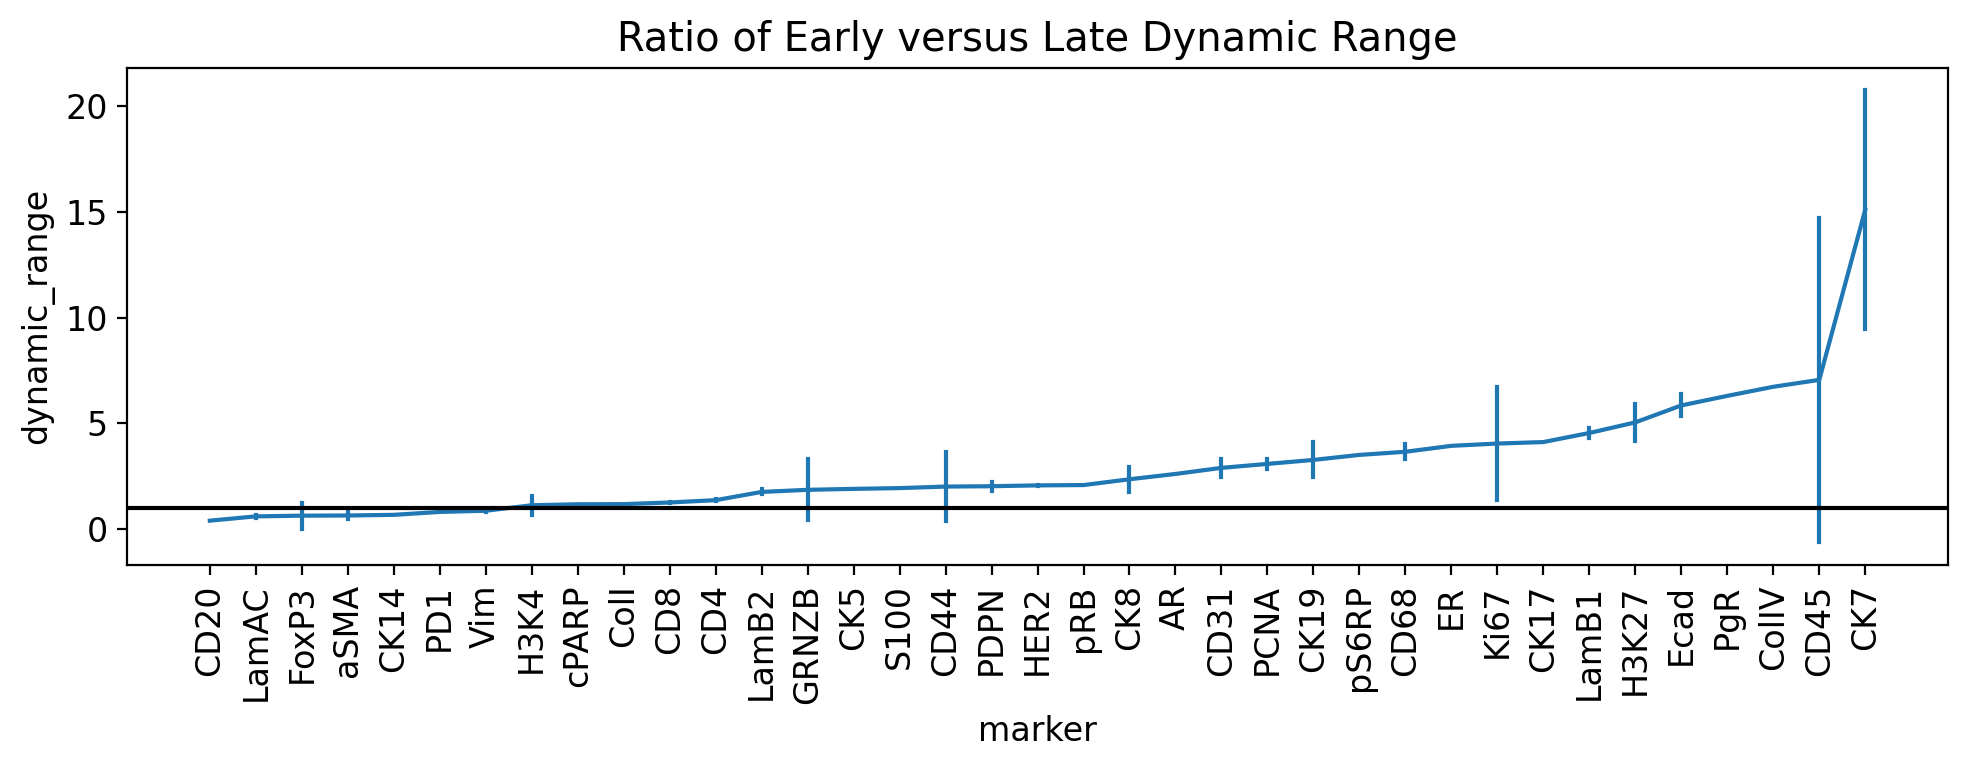

In [14]:
# Daynamic range
df_order = pd.DataFrame()
for s_marker in df_result.groupby('marker').dynamic_range.mean().sort_values().index:
    df_order = df_order.append(df_result[df_result.marker==s_marker])
fig, ax=plt.subplots(figsize=(10,4),dpi=200)
sns.lineplot(
    data=df_order, x="marker", y="dynamic_range", err_style="bars", ci='sd', ax=ax
)
ax.axhline(1,color='black')
labels=ax.get_xticklabels()
ax.tick_params(axis='x', labelrotation= 90) 
ax.set_title('Ratio of Early versus Late Dynamic Range')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_dynamic_range_ratio.png')

In [23]:
#percent antibodies earlier higher dynmic range
sum(df_order.groupby('marker').dynamic_range.mean() > 1)/len(df_order.groupby('marker').dynamic_range.mean())

0.8108108108108109

In [30]:
#percent antibodies less than 50% change
sum((df_order.groupby('marker').dynamic_range.mean() < 1.5) & (df_order.groupby('marker').dynamic_range.mean() > .5))/len(df_order.groupby('marker').dynamic_range.mean())

0.2972972972972973

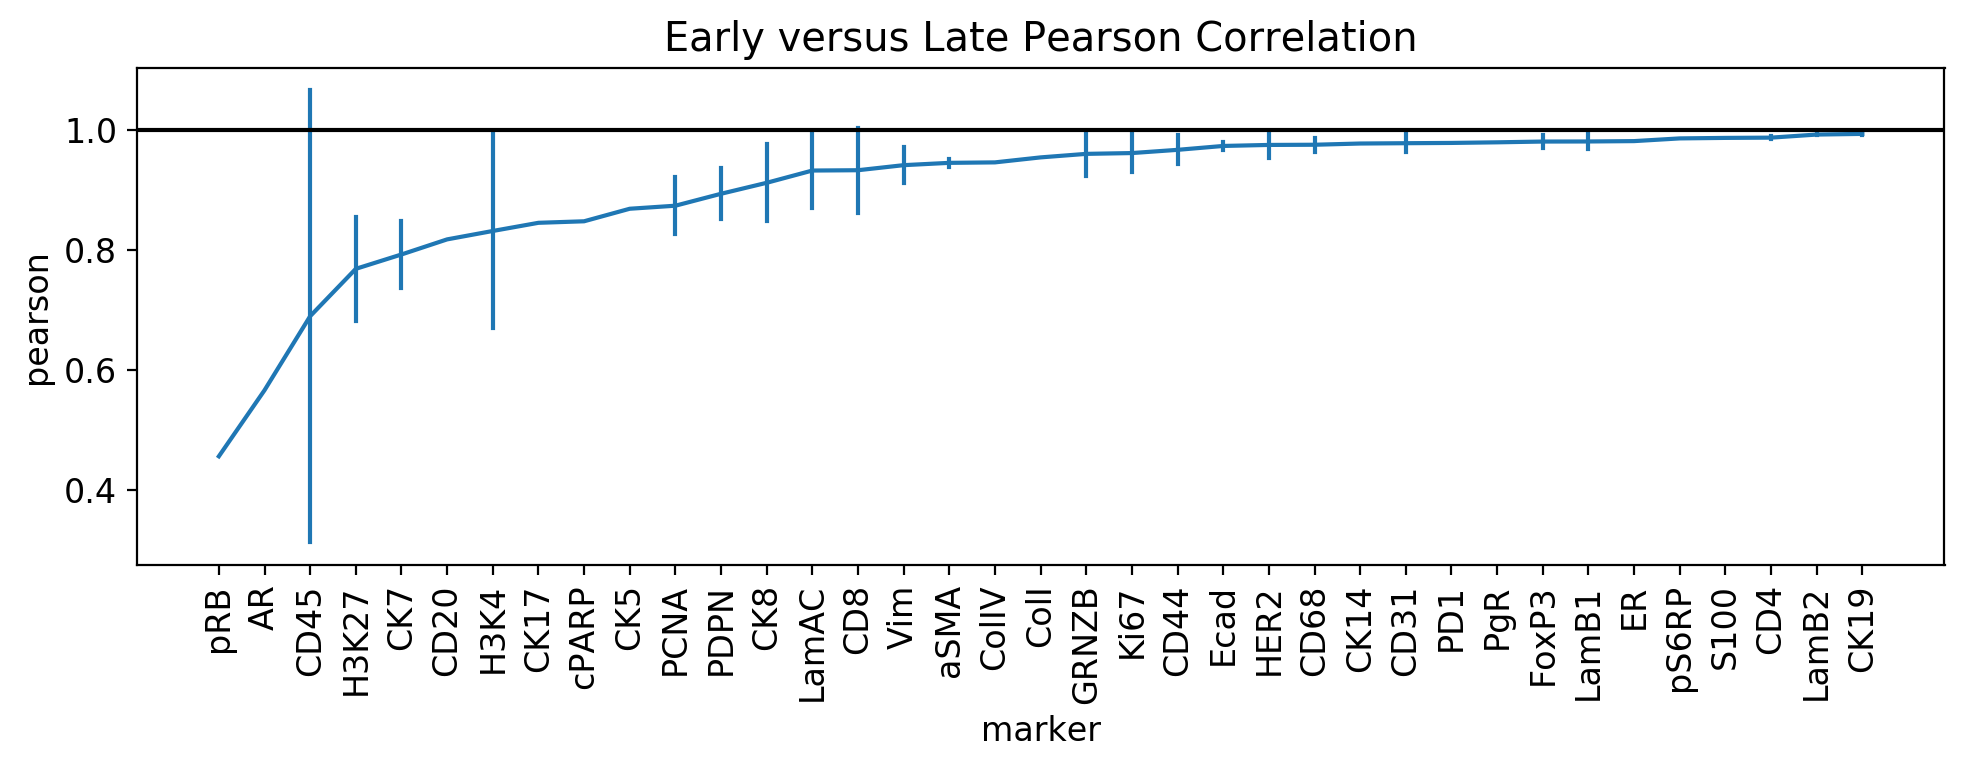

In [154]:
# correlation
df_order = pd.DataFrame()
for s_marker in df_result.groupby('marker').pearson.mean().sort_values().index:
    df_order = df_order.append(df_result[df_result.marker==s_marker])
fig, ax=plt.subplots(figsize=(10,4),dpi=200)
sns.lineplot(
    data=df_order, x="marker", y="pearson", err_style="bars", ci='sd', ax=ax
)
ax.axhline(1,color='black')
labels=ax.get_xticklabels()
ax.tick_params(axis='x', labelrotation= 90) 
ax.set_title('Early versus Late Pearson Correlation')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_pearson.png')

In [24]:
#percent antibodies high pearson
sum(df_order.groupby('marker').pearson.mean() > .8)/len(df_order.groupby('marker').pearson.mean())

0.8648648648648649

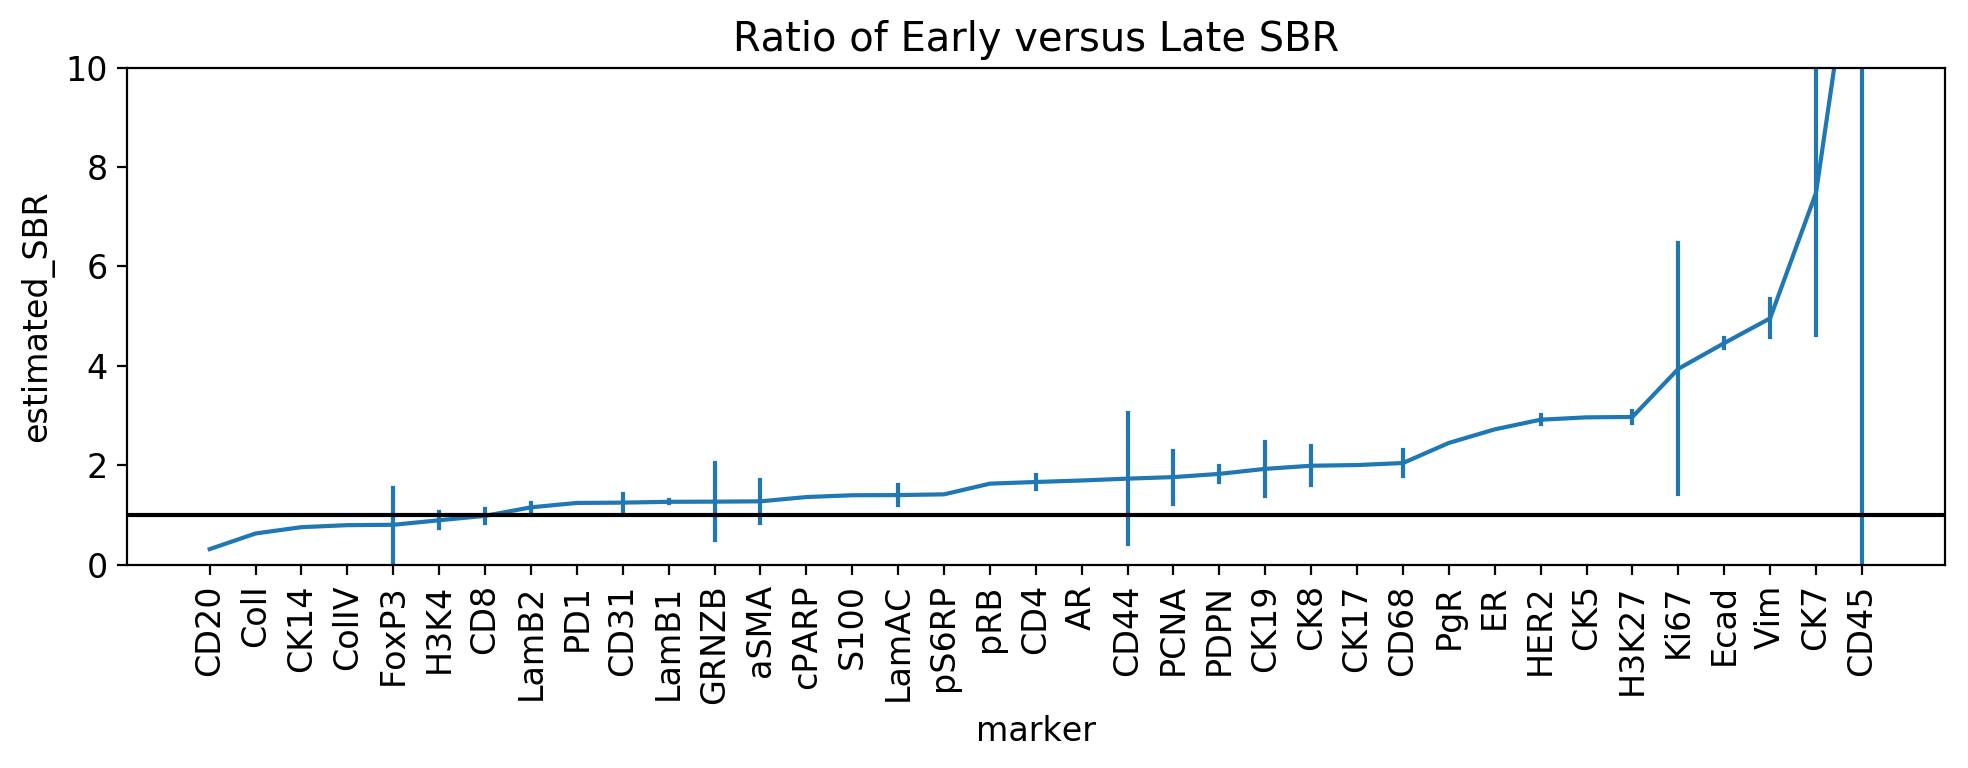

In [155]:
#SBR (use only scenes that are positive)
df_order = pd.DataFrame()
for s_marker in df_result.groupby('marker').estimated_SBR.mean().sort_values().index:
    df_order = df_order.append(df_result[df_result.marker==s_marker])
fig, ax=plt.subplots(figsize=(10,4),dpi=200)
sns.lineplot(
    data=df_order, x="marker", y="estimated_SBR", err_style="bars", ci='sd', ax=ax
)
ax.axhline(1,color='black')
labels=ax.get_xticklabels()
ax.tick_params(axis='x', labelrotation= 90) 
ax.set_title('Ratio of Early versus Late SBR')
ax.set_ylim(0,10)
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_SBR_ratio.png')

In [32]:
#percent est SBR earlier higher
sum(df_order.groupby('marker').estimated_SBR.mean() > 1)/len(df_order.groupby('marker').estimated_SBR.mean())

0.8108108108108109

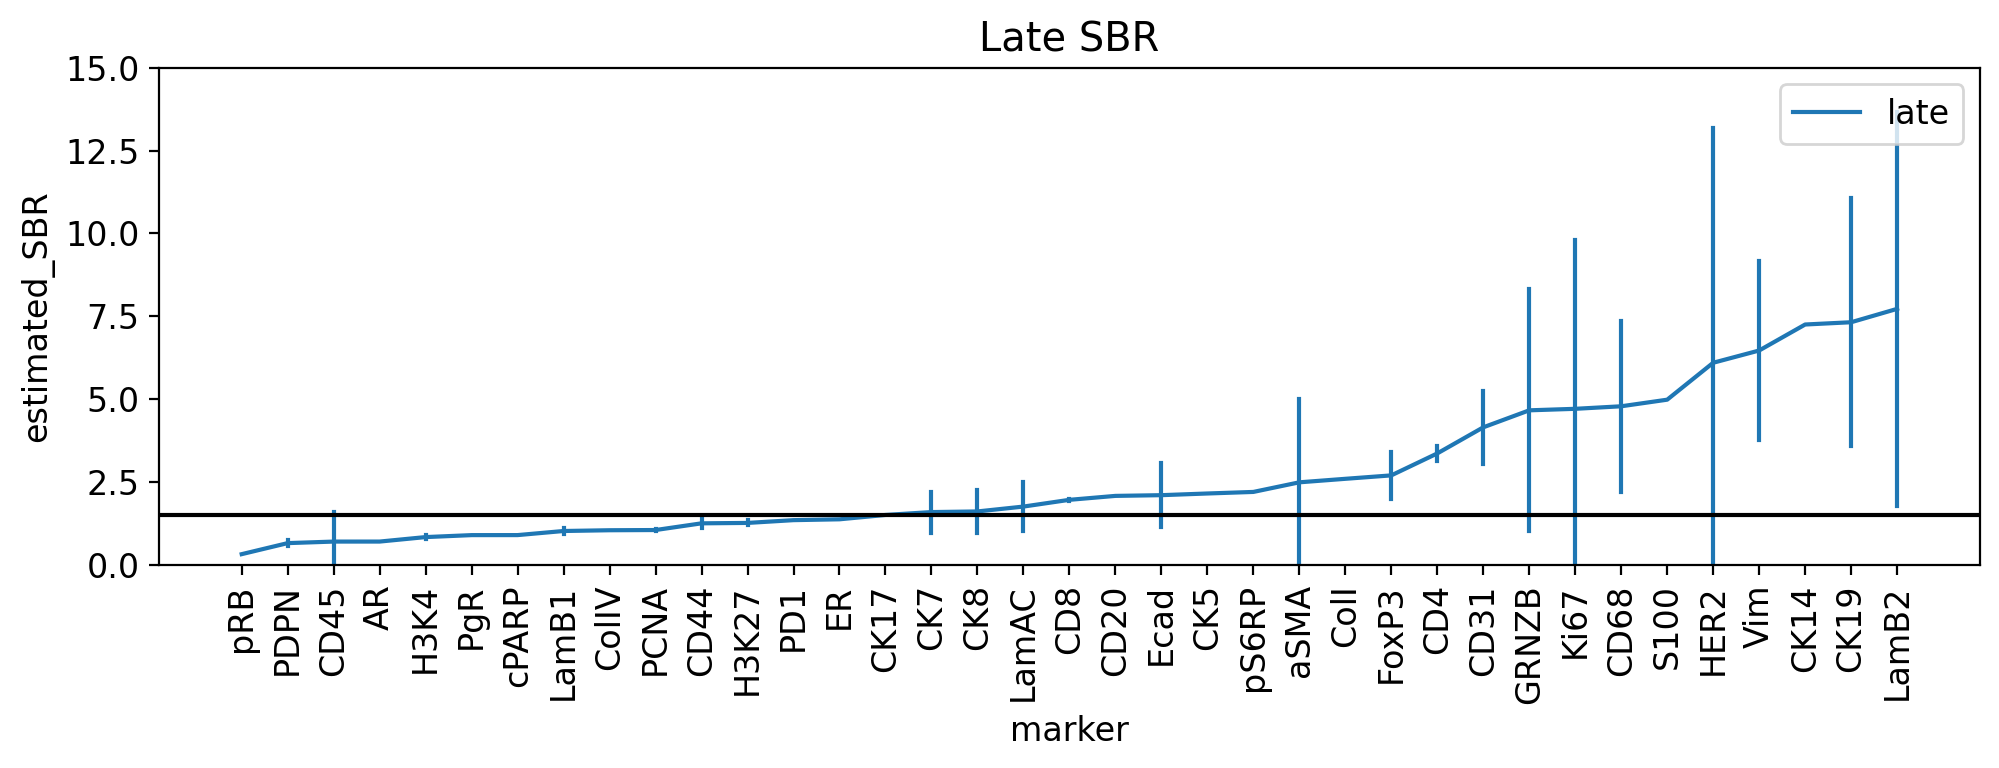

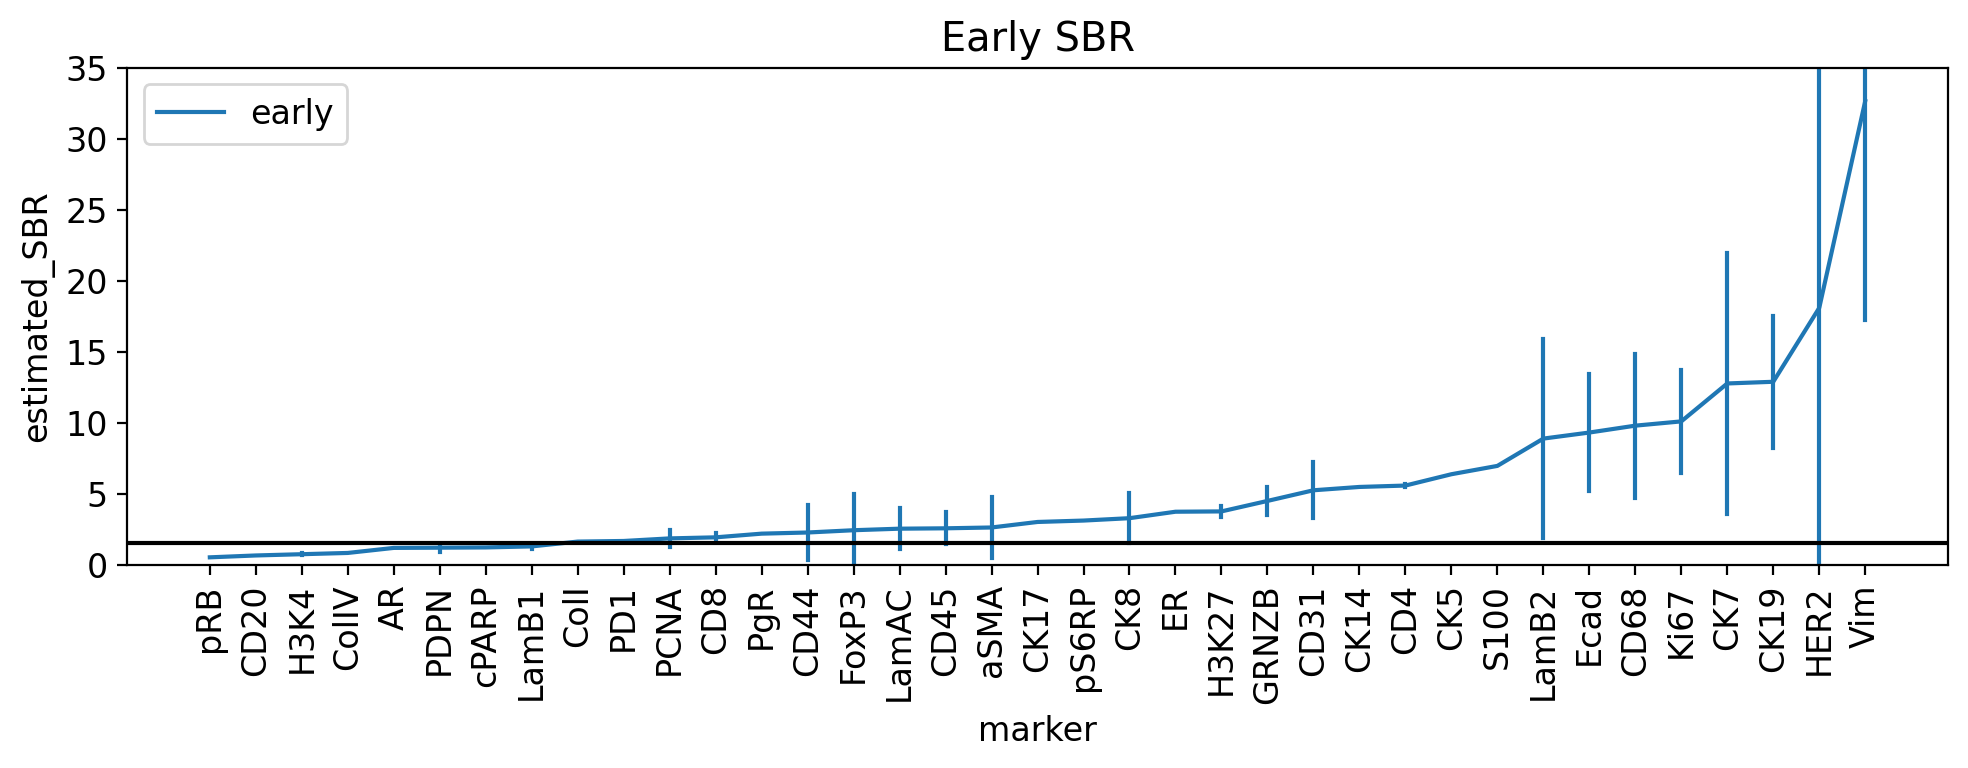

In [33]:
#SBR
df_order = pd.DataFrame()
for s_marker in df_late.groupby('marker').estimated_SBR.mean().sort_values().index:
    df_order = df_order.append(df_late[df_late.marker==s_marker])
fig, ax=plt.subplots(figsize=(10,4),dpi=200)
sns.lineplot(
    data=df_order, x="marker", y="estimated_SBR", label='late', ax=ax, err_style="bars", ci='sd',
)
ax.axhline(1.5,color='black')
labels=ax.get_xticklabels()
ax.tick_params(axis='x', labelrotation= 90) 
ax.set_title('Late SBR')
ax.set_ylim(0,15)
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_lateSBR.png')

df_order = pd.DataFrame()
for s_marker in df_early.groupby('marker').estimated_SBR.mean().sort_values().index:
    df_order = df_order.append(df_early[df_early.marker==s_marker])
fig, ax=plt.subplots(figsize=(10,4),dpi=200)
sns.lineplot(
    data=df_order, x="marker", y="estimated_SBR", label='early', ax=ax, err_style="bars", ci='sd',
)
ax.axhline(1.5,color='black')
labels=ax.get_xticklabels()
ax.tick_params(axis='x', labelrotation= 90) 
ax.set_title('Early SBR')
ax.set_ylim(0,35)
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_earlySBR.png')

In [35]:
print(sum(df_early.groupby('marker').estimated_SBR.mean() > 1.5)/len(df_early.groupby('marker').estimated_SBR.mean()))
print(sum(df_late.groupby('marker').estimated_SBR.mean() > 1.5)/len(df_late.groupby('marker').estimated_SBR.mean()))

0.7837837837837838
0.6216216216216216


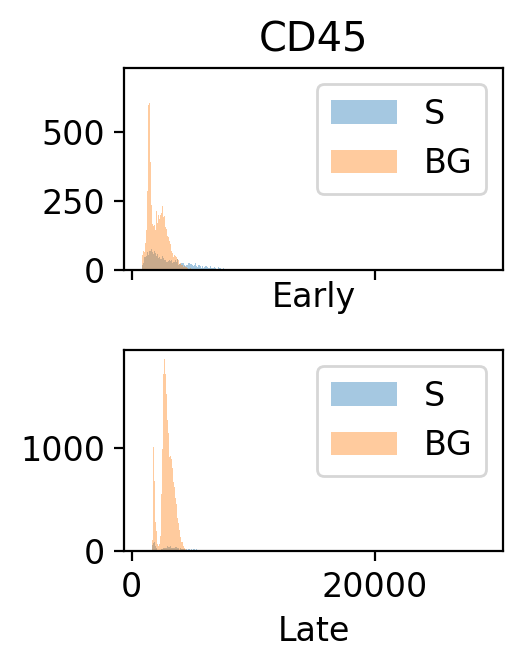

In [9]:
#produce single cell data/histograms

for s_fg, d_exclusive in dd_exclusive.items():
    fg_index = [item.split('Her2B-K157-6S_')[1] for item in  df_pos[df_pos.loc[:,s_fg]].index]
    for s_marker, s_bg in d_exclusive.items():    
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),sharex=True,dpi=200)
        ax=ax.ravel()
        #early
        bg_index = [item.split('Her2B-K157-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=500,ax=ax[0],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=500,ax=ax[0],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Early')
        #late
        se_fg = df_mi.loc[fg_index,f'{s_marker.split("_")[0]}b_{s_marker.split("_")[1]}']
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}b_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=500,ax=ax[1],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=500,ax=ax[1],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[1].legend()
        ax[1].set_xlabel('Late')
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_histogram_{s_marker.split("_")[0]}.png')
        if s_marker != 'CD45_Ring':
            plt.close(fig)


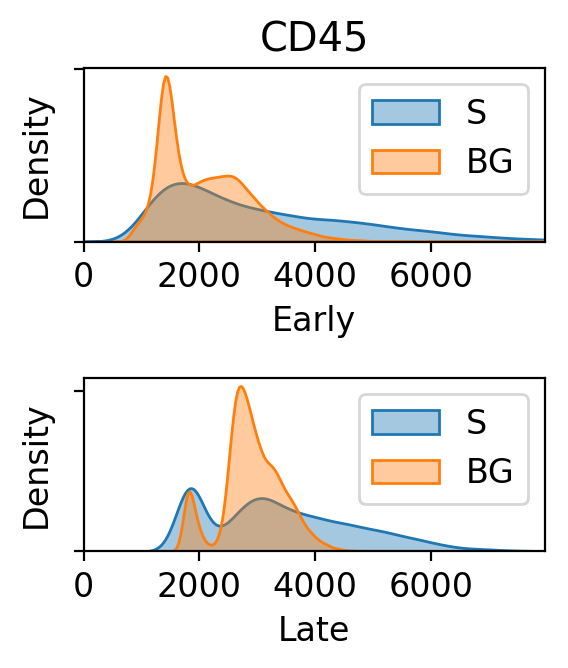

In [8]:
#kde 

for s_fg, d_exclusive in dd_exclusive.items():
    fg_index = [item.split('Her2B-K157-6S_')[1] for item in  df_pos[df_pos.loc[:,s_fg]].index]
    for s_marker, s_bg in d_exclusive.items():    
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),dpi=200)
        ax=ax.ravel()
        #early
        bg_index = [item.split('Her2B-K157-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        i_max = np.quantile(se_fg.append(se_bg),.998)
        sns.kdeplot(se_fg,ax=ax[0],shade=True,label='S',alpha=0.4,clip=(0,i_max))                       
        sns.kdeplot(se_bg,ax=ax[0],shade=True,label='BG',alpha=0.4,clip=(0,i_max))
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_yticklabels('')
        ax[0].set_xlabel('Early')
        ax[0].set_xlim(0,i_max)
        #late
        se_fg = df_mi.loc[fg_index,f'{s_marker.split("_")[0]}b_{s_marker.split("_")[1]}']
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}b_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.kdeplot(se_fg,ax=ax[1],shade=True,label='S',alpha=0.4,clip=(0,i_max))                       
        sns.kdeplot(se_bg,ax=ax[1],shade=True,label='BG',alpha=0.4,clip=(0,i_max))
        ax[1].legend()
        ax[1].set_yticklabels('')
        ax[1].set_xlabel('Late')
        ax[1].set_xlim(0,i_max)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K157/K157_kde_{s_marker.split("_")[0]}.png')
        if s_marker != 'CD45_Ring':
            plt.close(fig)
